In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from scipy.io import loadmat

from src import data, model, train, visualization

In [4]:
train_data_path = './data/train_32x32.mat'
test_data_path = './data/test_32x32.mat'

# Checking out data

Ok, let's see how big is the train dataset.

In [5]:
dataset = loadmat(train_data_path)
dataset['X'].shape

(32, 32, 3, 73257)

Dimensions are weird, this won't do. I will fix them and plot some examples of data.

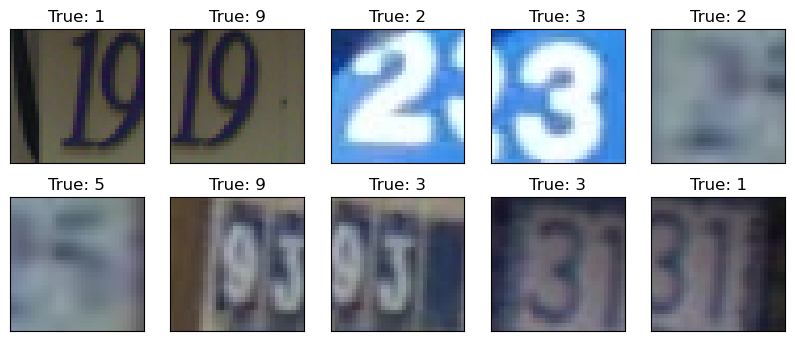

In [6]:
prep_data = np.transpose(dataset['X'], [3, 0, 1, 2]) # I make the last dimension first
labels = [l[0] for l in dataset['y'][:10]]
visualization.plot_images(prep_data[:10], labels, rows=2, cols=5)

Aha, that seems in order. Images are colored, I'll greyscale them for training.

But what about balance in classes?

In [7]:
unique = np.unique(dataset['y'], return_counts=True)
unique

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 array([13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,  4659,
         4948]))

Pupupu, that is terribly unbalanced. I will use the size of the smallest class for all classes.

Also, label '10' is for zeros, but we would need zeros themselves.

# Testing model architecture

The architecture is inspired by the second model from: [CNN: SVHN Street View Housing Number Digit](https://www.kaggle.com/code/mdriponmiah/cnn-svhn-street-view-housing-number-digit)

Let's get our data. The preprocess is happening inside the function.

torch.Size([46590, 1, 32, 32])


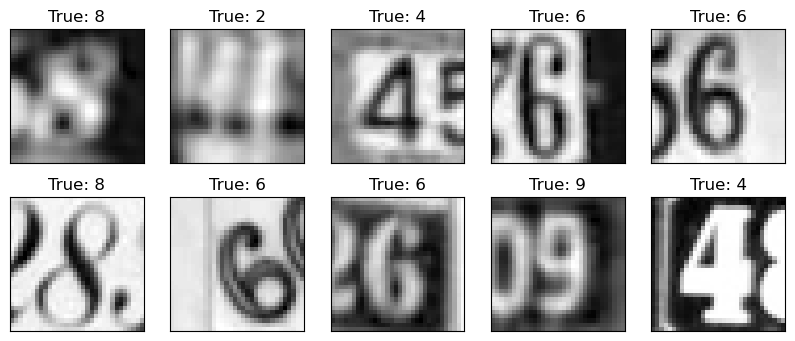

In [10]:
x_train, y_train = data.prepare_data(train_data_path)

print(x_train.shape)
visualization.plot_images(x_train[:10], y_train[:10], rows=2, cols=5)

See, it's already greyscale.

Now is the time to set up training: data loaders, loss function, optimiser and model itself.

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

split = int(0.8 * len(x_train))
train_dataset = data.SVHNDataset(x_train[:split], y_train[:split])
val_dataset = data.SVHNDataset(x_train[split:], y_train[split:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
cnn_model = model.DropoutCNN(0.2).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

Now I train model and get back the best checkpoint.

In [14]:
checkpoint, history = train.train_model(cnn_model, train_loader, validation_loader, 100, loss_fn, optimizer, disable_logs=True)

We all like cool graphs. Here's some cool graphs about training process.

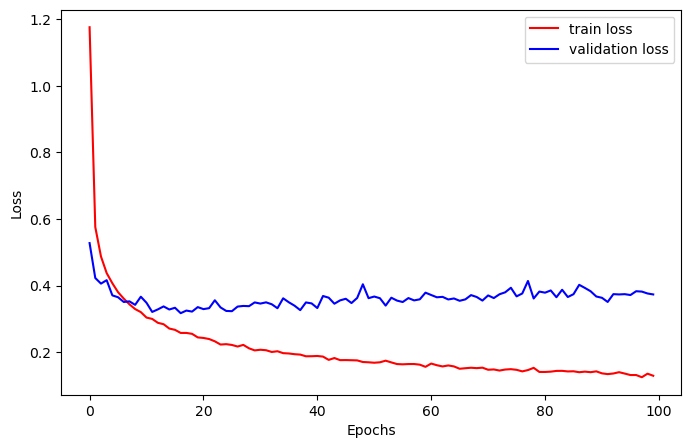

In [15]:
visualization.loss_plot(history['train_loss'], history['valid_loss'])

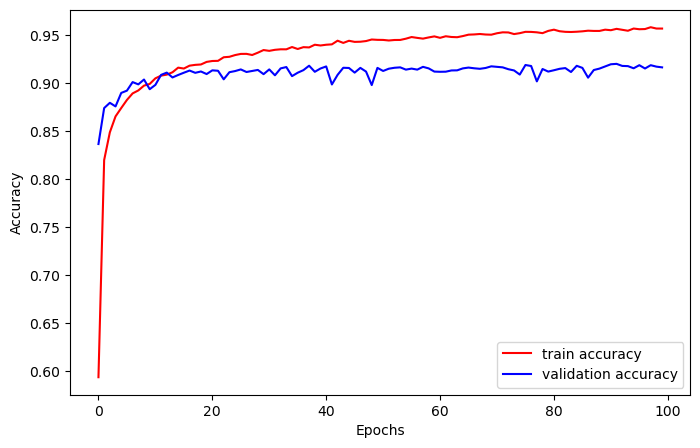

In [16]:
visualization.accuracy_plot(history['train_acc'], history['valid_acc'])

Looks like 100 epochs is more than enough.

Let's see how accurate our trained model.

In [17]:
x_test, y_test = data.prepare_data(test_data_path)

test_dataset = data.SVHNDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

trained_model = model.DropoutCNN(0.2)
trained_model.load_state_dict(checkpoint['state_dict'])

test_acc, test_loss = train.step(trained_model, test_loader, loss_fn, test=True)
print(f'Test accuracy: {test_acc * 100:.4f}%, test loss: {test_loss:.4f}')

Test accuracy: 90.8840%, test loss: 0.3912


And now would be a good time to print some predictions, maybe I'll catch some mistakes.

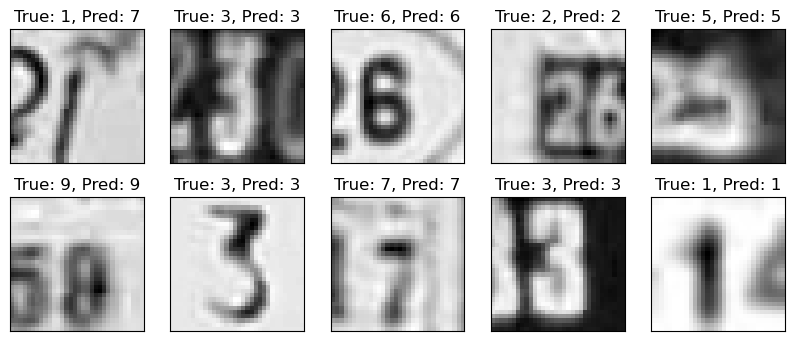

In [19]:
trained_model.eval()

predictions = []
with torch.inference_mode():
    for image, label in zip(x_test[:10], y_test[:10]):
        x = image.unsqueeze(0)
        logits = trained_model(x)
        predictions.append(int(torch.argmax(logits, dim=1)))

visualization.plot_images(x_test[:10], y_test[:10], rows=2, cols=5, predicted_labels=predictions)

My verdict - this architecture is good enough for my task.